First, construct the points where we're gonna compute the divergence.
The only nonisotropic grid is the one for the channel flow, therefore I'm generating the x and z coordinates randomly, but keeping y in check somewhat.
This shouldn't introduce any bias for the isotropic datasets.

In [1]:
import numpy as np
import pyJHTDB
from pyJHTDB.dbinfo import channel as info

npoints = 128
nskip = 4

x = np.random.random(
        size = (npoints, int(info['ny']/nskip-1), 3)).astype(np.float32)
x[..., 0] *= info['lx']
x[..., 1] *= info['dy'][::nskip][None, :x.shape[1]]
x[..., 1] += info['ynodes'][::nskip][None, :x.shape[1]]
x[..., 2] *= info['lz']

Now I'm actually calling the database, and requesting the velocity gradient.
Afterwards, I'm averaging over the first axis of x, since the y dependency is in the second axis.
For now, only M1Q4, M2Q8 and M2Q14 are implemented for the channel dataset, therefore they're the only ones I'm using

In [2]:
from pyJHTDB import libJHTDB

interp_info = [(44, 'FD4Lag4'),
               (104, 'M1Q4'),
               (208, 'M2Q8'),
               (214, 'M2Q14')]
divu = []

lJHTDB = libJHTDB()
lJHTDB.initialize()

#Add token
auth_token  = "edu.jhu.pha.turbulence.testing-201311" #Replace with your own token here
lJHTDB.add_token(auth_token)

for ii in interp_info:
    gradu = lJHTDB.getData(
                0.0,
                x,
                sinterp = ii[0],
                tinterp = 0,
                data_set = info['name'],
                getFunction = 'getVelocityGradient')
    divu.append(np.average(np.abs(
                        gradu[..., 0] +
                        gradu[..., 4] +
                        gradu[..., 8]), axis = 0) / 
                np.average(np.sqrt(
                        gradu[..., 0]**2 +
                        gradu[..., 4]**2 +
                        gradu[..., 8]**2), axis = 0))
lJHTDB.finalize()

(0, 0.5)

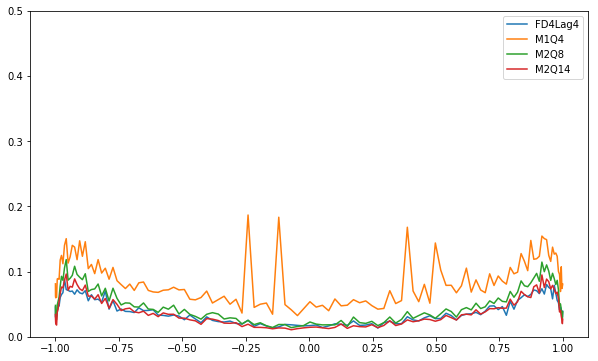

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
for i in range(len(divu)):
    ax.plot(info['ynodes'][::nskip][:divu[i].shape[0]],
            divu[i],
            label = interp_info[i][1])
ax.legend(loc = 'best')
ax.set_ylim(0, 0.5)